## Threshold and Subject-level Accuracy Analysis on RNAseq data
### Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann

The main objective of the notebook is to simulate the variation for a given subject at different levels of relative standard deviation (RSD) of Transcripts Per Million (TPM) and then to demonstrate how the score varies. 

We have three main outputs from the notebook. <br>
Output 1: Scatter plot showing the simulated classifier scores vs the original classifier scores for all subjects. <br>
Output 2: File containing the subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold for further analysis.<br>
Output 3: File containing the False Positives, False Negatives, True Positives and True Negatives across 243 subjects at a given %RSD for further analysis.<br>
Output 4: v-plot od classifier scores vs accuracies (agreement)<br>

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel("C:/Users/filip/OneDrive/Desktop/Molecular Stethoscope/Summer/ClusterMarkers_1819ADcohort.xlsx", sheet_name = 1)
# setting index row name to the gene id
myDF = myDF.set_index('gene_id')

#### Step 1: Data prep

In [4]:
#Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:,'Coeff'].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex='^\d+')

In [6]:
# group columns by patient id
grouped_cols = Patients_df.columns.str.split('-').str[0]

# group columns by patient id and r1/r2 suffixes
grouped = Patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
#Patients_df.head()

#### Step 2: Computing Zscores from TPM data

In [37]:
Patients_df['Mean']= Patients_df.mean(axis=1)
Patients_df['Std']=Patients_df.iloc[:,:-1].std(axis=1)
Patients_df['RSD'] = (Patients_df['Std'] / Patients_df['Mean']) * 100 # New code Filip
Patients_df.head()
#print(Patients_df.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
0,40.167869,43.221009,92.130259,36.867336,64.314305,63.696200,41.183321,35.534550,36.171542,191.524541,...,9.274524,14.666869,40.936737,299.701309,17.106801,7.189015,10.098540,53.615998,79.366824,148.028252
1,4.669515,8.401576,8.044477,7.796848,4.318270,7.806746,9.211167,12.195125,10.564085,10.079085,...,11.573087,12.342026,10.625224,7.469338,11.927871,16.497740,14.550720,10.860009,3.852071,35.470237
2,91.808686,52.448546,77.172398,32.860140,29.747566,52.015815,34.804606,130.916750,140.893862,58.207067,...,38.826779,37.958158,43.614536,33.142251,46.494429,40.536438,47.586401,66.017465,83.281169,126.150208
3,44.561230,8.633877,20.823619,7.644599,7.040536,12.787137,9.176064,42.415771,53.226069,14.426345,...,11.595814,7.649485,5.971085,3.887344,15.568394,14.297212,13.878777,17.132527,21.247423,124.018036
4,3.803395,2.503695,7.236350,3.961408,5.700403,8.033717,8.790777,10.042520,14.269996,3.171475,...,1.144207,2.506974,5.519857,0.000000,6.095647,2.254747,2.472533,6.439608,7.361212,114.311488


In [22]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x-x['Mean'])/x['Std']

In [35]:
# Computing and storing zscores
Patients_df_zScore = Patients_df.apply(lambda x: z_score(x), axis=1)
Patients_df_zScore.head()
#print(Patients_df_zScore.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
0,-0.169442,-0.130974,0.485269,-0.211028,0.134796,0.127008,-0.156648,-0.227821,-0.219795,1.737610,...,-0.558690,-0.490748,-0.159755,3.100607,-0.460005,-0.584967,-0.548308,0.0,0.324454,1.189570
1,-1.607057,-0.638212,-0.730915,-0.795199,-1.698241,-0.792630,-0.428041,0.346596,-0.076823,-0.202729,...,0.185115,0.384732,-0.060951,-0.880221,0.277217,1.463558,0.958110,0.0,-1.819267,6.388826
2,0.309689,-0.162929,0.133943,-0.398137,-0.435511,-0.168125,-0.374789,0.779279,0.899080,-0.093783,...,-0.326493,-0.336922,-0.269003,-0.394750,-0.234423,-0.305964,-0.221311,0.0,0.207294,0.722045
3,1.290934,-0.399970,0.173735,-0.446530,-0.474960,-0.204499,-0.374452,1.189959,1.698741,-0.127350,...,-0.260568,-0.446300,-0.525293,-0.623363,-0.073600,-0.133428,-0.153121,0.0,0.193681,5.030640
4,-0.357816,-0.534376,0.108542,-0.336350,-0.100112,0.216862,0.319706,0.489752,1.064043,-0.443660,...,-0.719059,-0.533931,-0.124639,-0.874496,-0.046420,-0.568195,-0.538609,0.0,0.125504,14.659842


In [39]:
patient_id= list(Patients_df_zScore.columns.values)
patient_id = patient_id[0:243]
#patient_id

#### Step 3: Defining Monte carlo simulation and classifier functions

In [42]:
#np.random.seed(46215423)

# Sampling function performing the Monte Carlo simulations
def Simulation(means, std, coefficients):
    return np.sum(np.multiply(coefficients, np.random.normal(means, std, size=(1, len(coefficients)))))

# Function to perform anti-logit operation on the linear score 
def cl_score(linear_score, gamma = 0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score

# Function to calculate subject wise mean and std of simulated scores 
def run_sim_one_patient_mean_sd(col,percent):
    std = [percent/100 * val for val in col]
    std = np.abs(std)
    temp_Sim = [Simulation(col, std, coefficients) for _ in range(numRuns)]
    return [np.mean(temp_Sim),np.std(temp_Sim)]

# Function to calculate the classifier score for each simulation of "num_runs" simulations, corresponding to each subject
def run_sim_one_patient(col, percent, num_runs):
    std = [percent/100 * val for val in col]
    std = np.abs(std)
    temp_Sim = np.asarray([cl_score(Simulation(col, std, coefficients)) for _ in range(num_runs)])
    return temp_Sim

# This score is the classifer linear score we want to compare with the simulated scores
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

#### Step 4: (Hyperparameters) We decide on number of simulations per subject (num_runs), assumed variation on TPM counts (uncertainty), and a classification threshold (thresh) ---
##### num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and std deviation determined by the variable 'uncertainty'.

In [26]:
num_runs = 1000
uncertainty = 25
thresh = 0.04874941

#### Step 5: Defining a function that plots the uncertainty around the threshold, and returns the figure, false positive count, false negative count, and number of subjects with unreliable classification for the specified variation and threshold.

In [41]:
def plot_uncert_at_thresh(num_runs , uncertainty, thresh ):
    
    
    """The purpose of this function is to produce 2 things based on %RSD (uncertainty), threshold (thresh), number of MC simulations (num_runs) :
    1. Figure to show the scattering based on classifier scores of simulations against subject.
    2. False Positves/Negatives
    
    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score 
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code 
        will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  A scatter plot will be produced using simulation scores on y-axis and subject scores on x-axis, two perpendicular lines passing the thresholds on x and y axis
     will  categorize the scatter dots into FP, FN , TP and TN.
    
    
    Example input: sub_accuracy(400, 50, 0.87)
    """
    
    false_pos = 0 # counter, stores number of points on second quadrant
    false_neg = 0
    num_subj_unreliable = np.zeros(243) # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    fig = plt.figure(figsize=(10,10))
    #for i in range(243):
    for i in range(243):
        scores = run_sim_one_patient(Patients_df_zScore.iloc[:, i], uncertainty, num_runs)
        y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, i]))
        x_data = np.ones_like(scores) * y_0
        y_data = scores
        colour = np.zeros_like(x_data)
        for j in range(len(x_data)):
            if x_data[j] > thresh and y_data[j] < thresh:
                colour[j] = 1
                false_neg = false_neg + 1
                num_subj_unreliable[i] = 1
            elif x_data[j] < thresh and y_data[j]> thresh:
                colour[j] = 2
                false_pos = false_pos + 1
                num_subj_unreliable[i] = 1
        plt.scatter(x_data, y_data, c=colour, cmap = 'Dark2_r' ,alpha = 0.15, s=100)
    plt.axvline(x = thresh, color = 'g', linestyle= '--')
    plt.axhline(y = thresh, color = 'g', linestyle= '--')
    #plt.xlim([0.425, 0.575])
    #plt.ylim([0.425, 0.575])
    plt.xlabel("Classifier score", fontsize= 24)
    plt.ylabel("Simulated scores", fontsize = 24)
    plt.title('Uncertainty around threshold', fontsize = 28)
    # Below are the labels of agreement and disagreement
    A = plt.scatter([0],[0], alpha =0) # dummy plot for legend
    B = plt.scatter([0],[0],  alpha =0) # dummy plot for legend
    plt.text(0, 0.8, 'A', fontsize = 20)
    plt.text(0, 0, 'B', fontsize =20)
    plt.text(0.8, 0, 'B', fontsize =20)
    plt.text(0.8, 0.8, 'A', fontsize =20)
    plt.legend([A,B], ['A : Agreement', 'B : Disagreement'])
    #plt.savefig('figures/uncert_around_thresh_25_RSD.png')

    return [ fig , false_pos , false_neg , (np.sum(num_subj_unreliable)) ]

In [28]:
#cl_score(-2.97108439) # checking the threshold value in probability

In [29]:
### Check that random seeding is working by running this cell several times... it is working.
#np.random.seed(2)
#scores = run_sim_one_patient(Patients_df_zScore.iloc[:, 1], uncertainty, num_runs)
#print(scores)
#len(scores)

In [30]:
# Example for using the above function
# plot_uncert_at_thresh(100,50,0.86)
#plot_uncert_at_thresh(num_runs,uncertainty,thresh)

#### Step 6: Accuracy Analysis: We are computing two things here:
#### 1: Accuracy- we are computing subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold. After calculating the total number of FN and FP, we subtract it with the total number of simulations, the resultant is then divided by the total number of simulations to provide us the accuracy for each subject. We perform this analysis for each %RSD which gives us a file of 243 subjects and their accuracies at each %RSD in the range.
#### 2: FP and FN- Here we calculate the total number of FP, FN, TP and TN across 243 subjects at a given %RSD. 

In [31]:
def sub_accuracy(uncertainty_range, thresh, num_runs):
    """The purpose of this function is to calculate 2 things based on %RSD (uncertainty_range), threshold (thresh), number of MC simulations (num_runs) :
    1. subject accuracy based on number of simulations : this info is provided in a dataframe called "accuracy_df"
    2. True Positives/Negatives, False Positves/Negatives: this info is provided in a dtatframe called "false_pos_df"
    
    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score 
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  the process 2-7 will be repeated for each %RSD input. 
    
    
    Example input: sub_accuracy([20, 40, 50], 0.87, 400)  -> note that uncertainty_range should be given in a form of a list even if giving single value.
    """
    global real_score
    global accuracy_df
    global y_data
    global x_data
    global Sub_score 
    global false_pos_df
    global fig
   
    np.random.seed(46215423)
    
    real_score = np.zeros(243)
    accuracy = np.zeros(243)
    
    false_pos_df = pd.DataFrame(columns = uncertainty_range, index= ['simulations in agreement with subject', 'simulations in disagreement with subject', 'Unreliable Subjects'])
    
    num_subj_unreliable = np.zeros(243) # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    false_pos_series=[]
   
    AD=0
    NCI=0
    Sub_score = pd.Series(real_score)
    accuracy_df= pd.DataFrame(columns= uncertainty_range)
    
    
    for i in range(len(uncertainty_range)):
        false_pos = 0 # counter, stores number of points on second quadrant
        false_neg = 0
        true_pos = 0
        true_neg = 0
        FN = []
        FP = []
        TN = []
        TP = []
        
        for j in range(243):
            scores = run_sim_one_patient(Patients_df_zScore.iloc[:, j], uncertainty_range[i], num_runs)
            y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, j]))
            x_data = np.ones_like(scores) * y_0
            y_data = scores
            colour = np.zeros_like(x_data)
            false_neg = 0
            false_pos = 0
            true_neg=0
            true_pos=0
            for k in range(len(x_data)):
                if x_data[k] > thresh and y_data[k] < thresh:
                    false_neg = false_neg + 1
                    num_subj_unreliable[j] = 1
                elif x_data[k] < thresh and y_data[k]> thresh:
                    false_pos = false_pos + 1
                    num_subj_unreliable[j] = 1
                elif x_data[k]> thresh and y_data[k] > thresh:
                    true_pos = true_pos +1
                elif x_data[k] < thresh and y_data[k] < thresh:
                    true_neg = true_neg +1  

            accuracy[j] = (num_runs-(false_neg)-(false_pos))/num_runs
            real_score[j] = y_0


            FN.append(false_neg)
            FP.append(false_pos)
            TN.append(true_neg)
            TP.append(true_pos)
        unreliable_subjects= str(np.sum(num_subj_unreliable))
        accuracy_series = pd.Series(accuracy)
        
        disagreement = sum(FN) + sum(FP)
        agreement= sum(TN) + sum(TP)
       
        accuracy_df[accuracy_df.columns[i]] = accuracy_series*100
        false_pos_df[false_pos_df.columns[i]]= [agreement, disagreement, unreliable_subjects]
        Sub_score = pd.Series(real_score)    
        accuracy_df['Classifier Score']= Sub_score
        
        
        dfm = accuracy_df.melt('Classifier Score', var_name='%RSD', value_name='Agreement')   
    fig = sns.relplot(x= "Classifier Score" , y="Agreement", hue='%RSD', data=dfm, kind='line', linewidth= 1, palette = "rainbow")
    accuracy_df['Patient ID'] = patient_id
    accuracy_df = accuracy_df.set_index('Patient ID')
    for l in range (len(Sub_score)):
            if Sub_score[l]>thresh:
                AD= AD+1
            else: NCI =NCI+1
    return ( print("AD=",AD), print("NCI=",NCI), accuracy_df, false_pos_df, fig)

AD= 124
NCI= 119


(None,
 None,
                25  Classifier Score
 Patient ID                         
 11174       100.0          1.000000
 11178       100.0          0.001793
 11182       100.0          0.998355
 11186       100.0          0.556631
 11190       100.0          0.933300
 ...           ...               ...
 5683        100.0          0.000167
 5702        100.0          0.000624
 5706        100.0          0.000779
 5767        100.0          0.000131
 5784         91.0          0.027903
 
 [243 rows x 2 columns],
                                              25
 simulations in agreement with subject     24223
 simulations in disagreement with subject     77
 Unreliable Subjects                         6.0,
 <seaborn.axisgrid.FacetGrid at 0x2bf2e01f5e0>)

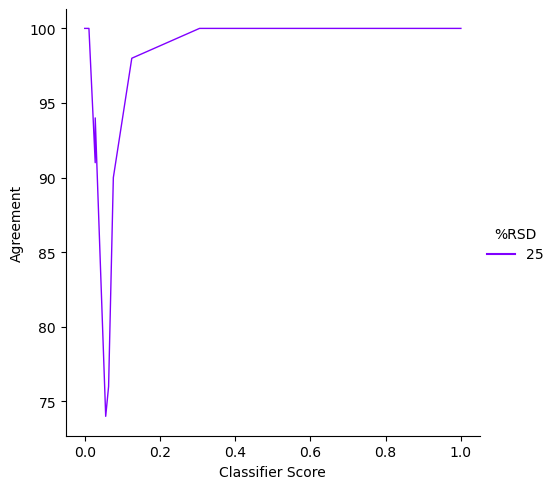

In [32]:
sub_accuracy([25],thresh,100)

In [44]:
disagreement_df=  accuracy_df[accuracy_df[50] < 100]
disagreement_df = disagreement_df.sort_values(by= [50], ascending= False)
disagreement_df.shape

KeyError: 50

In [45]:
disagreement_df.to_csv("subject-wise disagreement.csv")

NameError: name 'disagreement_df' is not defined

In [46]:
false_pos_df

,25
simulations in agreement with subject,24223
simulations in disagreement with subject,77
Unreliable Subjects,6.0


In [47]:
accuracy_df

,25,Classifier Score
Patient ID,,
11174,100.0,1.000000
11178,100.0,0.001793
11182,100.0,0.998355
11186,100.0,0.556631
11190,100.0,0.933300
...,...,...
5683,100.0,0.000167
5702,100.0,0.000624
5706,100.0,0.000779


In [19]:
# sub_accuracy([10, 25, 50], 0.86, 100)
# sub_accuracy([10, 25, 50], 0.90, 100)
# sub_accuracy([10, 25, 50], 0.80, 100)

#### Output 2: accuracy file for each subject at each %RSD
ex: accuracy_df.to_csv("Subject accuracy at variations.csv")
#### Output 3: Datafile containing FP, FN, TP, TN from simulations for each %RSD
 ex: false_pos_df.to_csv("FP and FN analysis of simulations for %RSD.csv")
#### Output 4: v-plot fig of classifier scores vs agreement.